In [18]:
# installing appropiate libraries and packages

%pip install pandas
%pip install numpy
%pip install rouge-score
%pip install matplotlib
%pip install nltk

You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer
import nltk
import heapq
import re

from nltk.corpus import stopwords
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/asharfarooq/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# loading full dataset in
movies = pd.read_csv('rotten_tomatoes_movies.csv')
reviews = pd.read_csv('rotten_tomatoes_critic_reviews.csv')

In [4]:
# dropping movies that don't have ground truth
filteredMovies = movies.dropna(subset = "critics_consensus")

In [86]:
# parameter: how many movies to conduct the analysis for (CHANGE THIS)
to_keep = 1000

furtherFilteredMovies = filteredMovies[:to_keep]

In [87]:
movies_to_keep = furtherFilteredMovies[['rotten_tomatoes_link']]

# data table for each critic review that has ground truth
combined_data = movies_to_keep.merge(reviews, how = 'left')

In [88]:
combined_data.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...


In [89]:
# dropping data that don't have review values
filtered_combined_data = combined_data.dropna(subset = "review_content")

In [90]:
# grouping critic reviews by each movie and then appending together each review for a given given
filtered_appended_reviews = \
pd.DataFrame(filtered_combined_data.groupby("rotten_tomatoes_link")['review_content'].apply(lambda x: ','.join(x))).reset_index()

In [91]:
# pulling together a table table that represents each movie and the pre_hypothesis for the summary(joining together of all the reviews for a movie)
final_data = \
furtherFilteredMovies.merge(filtered_appended_reviews, on = 'rotten_tomatoes_link')[['movie_title', 'critics_consensus', 'review_content']]

In [92]:
final_data.head()

,movie_title,critics_consensus,review_content
0,Percy Jackson & the Olympians: The Lightning T...,Though it may seem like just another Harry Pot...,A fantasy adventure that fuses Greek mythology...
1,Please Give,Nicole Holofcener's newest might seem slight i...,"Like Holofcener's previous pictures, Please Gi..."
2,10,Blake Edwards' bawdy comedy may not score a pe...,10 (1979) is known for its numerical rating sy...
3,12 Angry Men (Twelve Angry Men),Sidney Lumet's feature debut is a superbly wri...,"A film with texture, humour and relevance at a..."
4,"20,000 Leagues Under The Sea","One of Disney's finest live-action adventures,...",[The] embodiment of Disney at his best -- fami...


In [93]:
# the human-summarizations of all the reviews for a movie
ground_truth = list(final_data['critics_consensus'])

In [101]:
# the appended reviews for a given movie
appended_reviews_pre_hypotheses = list(final_data['review_content'])

In [124]:
final_hypothesis = []
stopwords_list = stopwords.words()

# upper bound for number of characters in a sentence for a sentence to be included in a potential summary (parameter: change this)
UPPER_BOUND_FOR_SENTENCE_LENGTH_TO_INCLUDE_IN_SUMMARY = 250 

# number of top-weighted sentences to include in the summary (parameter: change this)
NUM_TOP_SENTENCES = 10

for each_movie_appended_reviews_hypothesis in appended_reviews_pre_hypotheses:
    sentence_list_full_review_original_text = sent_tokenize(each_movie_appended_reviews_hypothesis)

    # cleaning and processing the original pre_hypothesis of the appended reviews for a given movie (removing special characters)
    cleaned_review_text = re.sub('[^A-Za-z0-9]+', '', each_movie_appended_reviews_hypothesis)

    # word frequencies logic for each word in the entire cleaned movie review pre_hypothesis (appended movie reviews)
    word_frequencies = {}
    for each_word in word_tokenize(cleaned_review_text):
        if each_word not in stopwords_list:
            if each_word not in word_frequencies:
                word_frequencies[each_word] = 1
            else:
                word_frequencies[each_word] += 1

    max_freq_count = max(word_frequencies.values())

    for each_word in word_frequencies.keys():
        word_frequencies[each_word] = (word_frequencies[each_word]/max_freq_count)
    
    # sentence weights (summing together word frequencies values for each word in a sentence that is not too long)
    sentence_weights = {}
    for each_sentence in sentence_list_full_review_original_text:
        for word in word_tokenize(each_sentence.lower()):
            if word in word_frequencies.keys():
                if len(each_sentence.split(' ')) < UPPER_BOUND_FOR_SENTENCE_LENGTH_TO_INCLUDE_IN_SUMMARY:
                    if each_sentence not in sentence_weights:
                        sentence_weights[each_sentence] = word_frequencies[word]
                    else:
                        sentence_weights[each_sentence] += word_frequencies[word]

    top_summary_sentences = heapq.nlargest(NUM_TOP_SENTENCES, sentence_weights, key=sentence_weights.get)

    summary_hypothesis = ' '.join(top_summary_sentences)
    final_hypothesis.append(summary_hypothesis)

KeyboardInterrupt: 

In [107]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2'], use_stemmer=True)

#running the ROUGE evaluation for certain subset of ground truth and hypothesis pairs
num_of_iterations = 1000
all_rouges_1_scores = []
all_rouges_2_scores = []
for i in range(num_of_iterations):
    all_scores_obj = scorer.score(final_hypothesis[i], ground_truth[i])
    all_rouges_1_scores.append(all_scores_obj["rouge1"])
    all_rouges_2_scores.append(all_scores_obj["rouge2"])

In [108]:
# building up metric results for Rouge 1

rouge_1_precisions = []
rouge_1_recall = []
rouge_1_f1 = []
for each_rouge_1_score in all_rouges_1_scores:
    rouge_1_precisions.append(each_rouge_1_score.precision)
    rouge_1_recall.append(each_rouge_1_score.recall)
    rouge_1_f1.append(each_rouge_1_score.fmeasure)

In [109]:
# analyzing rouge 1 results

avg_rouge_1_precision_score = np.average(rouge_1_precisions)
avg_rouge_1_recall_score = np.average(rouge_1_recall)
avg_rouge_1_f1_score = np.average(rouge_1_f1)

print(f'The average precision value for the rouge 1 scores is {avg_rouge_1_precision_score}')
print(f'The average recall value for the rouge 1 scores is {avg_rouge_1_recall_score}')
print(f'The average f1 value for the rouge 1 scores is {avg_rouge_1_f1_score}')

The average precision value for the rouge 1 scores is 0.6842528824975943
The average recall value for the rouge 1 scores is 0.029536626928341796
The average f1 value for the rouge 1 scores is 0.05378149695785238


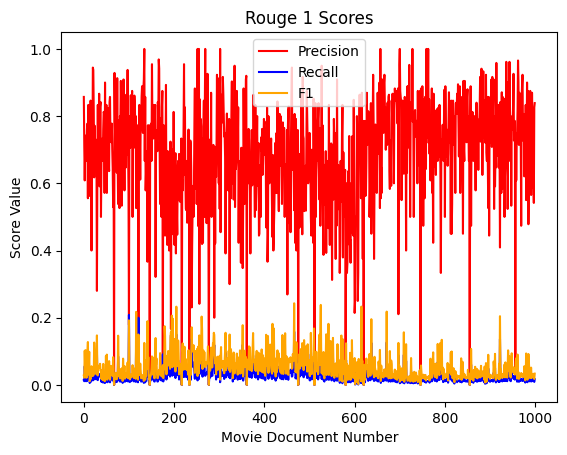

In [111]:
# graping rouge 1 metrics

x_axis = range(num_of_iterations)

plt.title("Rouge 1 Scores")
plt.xlabel("Movie Document Number")
plt.ylabel("Score Value")
plt.plot(x_axis, rouge_1_precisions, color ="red", label="Precision")
plt.plot(x_axis, rouge_1_recall, color ="blue", label= "Recall")
plt.plot(x_axis, rouge_1_f1, color ="orange", label="F1")

plt.legend()
plt.show()

In [112]:
# building up metric results for Rouge 2

rouge_2_precisions = []
rouge_2_recall = []
rouge_2_f1 = []
for each_rouge_2_score in all_rouges_2_scores:
    rouge_2_precisions.append(each_rouge_2_score.precision)
    rouge_2_recall.append(each_rouge_2_score.recall)
    rouge_2_f1.append(each_rouge_2_score.fmeasure)

In [114]:
# analyzing rouge 2 results

avg_rouge_2_precision_score = np.average(rouge_2_precisions)
avg_rouge_2_recall_score = np.average(rouge_2_recall)
avg_rouge_2_f1_score = np.average(rouge_2_f1)

print(f'The average precision value for the rouge 2 scores is {avg_rouge_2_precision_score}')
print(f'The average recall value for the rouge 2 scores is {avg_rouge_2_recall_score}')
print(f'The average f1 value for the rouge 2 scores is {avg_rouge_2_f1_score}')

The average precision value for the rouge 2 scores is 0.21090353685951638
The average recall value for the rouge 2 scores is 0.007588406500924251
The average f1 value for the rouge 2 scores is 0.014170975371229291


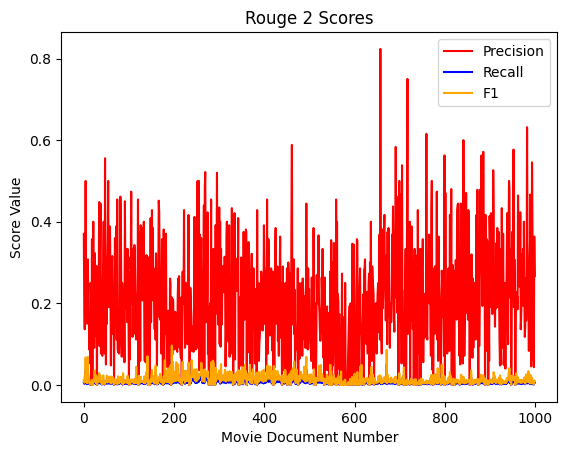

In [115]:
# graping rouge 2 metrics

x_axis = range(num_of_iterations)

plt.title("Rouge 2 Scores")
plt.xlabel("Movie Document Number")
plt.ylabel("Score Value")
plt.plot(x_axis, rouge_2_precisions, color ="red", label="Precision")
plt.plot(x_axis, rouge_2_recall, color ="blue", label= "Recall")
plt.plot(x_axis, rouge_2_f1, color ="orange", label="F1")

plt.legend()
plt.show()